In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
# from sklearn.manifold import TSNE
import sqlite3
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# from sklearn import cross_validation

In [2]:
# df = pd.read_sql("SELECT * FROM TABLE",con)
con = sqlite3.connect('./database.sqlite')
df = pd.read_sql_query("""SELECT *
FROM Reviews
""",con)  

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Preprocessing

In [4]:
# df.Score.value_counts()
df = df.dropna()
# df.shape
# https://stac|koverflow.com/questions/19913659/pandas-conditional-creation-of-a-series-dataframe-column
df['review'] = np.where(df['Score']>3, 'positive', 'negative')
df.review.value_counts()

positive    443777
negative    124677
Name: review, dtype: int64

In [5]:
#i will be using only 10% of available data  
#this assignments
#https://stackoverflow.com/questions/38085547/random-sample-of-a-subset-of-a-dataframe-in-pandas
# sample = np.random.uniform(0,len(df),int(len(df)*0.10))
# df_sample = df.iloc[sample]
df_sample = df

#### removing duplicate copies 

In [6]:
sorted_data=df_sample.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
DataPoints, Features = final.shape
l= final["review"].unique()
x,y= final["review"].value_counts()
print("Final Data \n")
# print(len(l))
print ("Total number of Datapoints -",DataPoints,'\n\n'
      'Total Number Features or Independent Variable -',Features-1,'\n')
print('The Positive review has label \"{}\" and \"{}\" datapoint \n'.format(l[0],x))
print('The Negatve review has class label \"{}\" and \"{}\" datapoints'.format(l[1],y))

Final Data 

Total number of Datapoints - 393931 

Total Number Features or Independent Variable - 10 

The Positive review has label "positive" and "307052" datapoint 

The Negatve review has class label "negative" and "86879" datapoints


### Text preprocessing

In [8]:
import itertools

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext.lower()

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\';|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

# # cleaned Text
final['CleanedText']=list(map(cleanhtml,(map(cleanpunc,final['Text']))))
final['CleanedSummary']=list(map(cleanhtml,(map(cleanpunc,final['Summary']))))

In [9]:

stop = set(stopwords.words('english')) #set of stopwords

sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
def list_of_words(sentence):
    word=[]
    for cleaned_words in sentence.split():
        if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
#             s=(sno.stem(cleaned_words.lower())).encode('utf8')
#             word.append(s) #list of all words used to describe positive reviews

            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower()))#.encode('utf8')  #remoiving utf give 
                word.append(s) #list of all words used to describe positive reviews
            else:
                continue
        else:
            continue
#     return word
#   joing string for dataframes
    words=' '.join(str(e) for e in word)
    return words

# positive=(final[final['review']=="positive"])
# all_positive_words=list(itertools.chain(*list(map(list_of_words,positive['CleanedText']))))

# negative=(final[final['review']=="negative"])
# all_negative_words=list(itertools.chain(*list(map(list_of_words,negative['CleanedText']))))
# cleaned text without stopwords


## creating text without stopwords
final['WoutStopWords']=list(map(list_of_words,final['CleanedText']))
## creating sumary without stopwords
# final['WoutStopWordsSummary']=list(map(list_of_words,final['CleanedSummary']))

In [10]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,review,CleanedText,CleanedSummary,WoutStopWords
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,positive,in june i saw a charming group of roses all be...,nice cadence catchy rhymes,june saw charm group rose begin droop pep chic...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,positive,this is a fun way for children to learn their ...,chicken soup with rice months,fun way children learn month year learn poem t...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",positive,i grew up reading these sendak books and watc...,love the book miss the hard cover version,grew read sendak book watch realli rosi movi i...
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,Get the movie or sound track and sing along wi...,positive,get the movie or sound track and sing along wi...,a classic,get movi sound track sing along carol king gre...
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,positive,a very entertaining rhyming story--cleaver and...,chicken soup with rice,entertain rhyme catchi illustr imagin fit righ...


## Creating  Training and test dataset

In [11]:
#i will be using only 10% of available data  
#this assignments
#https://stackoverflow.com/questions/38085547/random-sample-of-a-subset-of-a-dataframe-in-pandas
sample = np.random.uniform(0,len(final),int(len(final)*0.10))
final_sample = final.iloc[sample]

In [14]:
# creating dataset by removing unwanted data
X = final_sample[['Time',"WoutStopWords",'review']]
X = X.sort_values(['Time'],ascending=True)
X.head()

,Time,WoutStopWords,review
150500,940809600,rememb see show air televis year ago child sis...,positive
374338,997228800,continu amaz shoddi treatment movi get dvd rel...,negative
361316,1010275200,year tri simul truli italian espresso cappucci...,positive
374419,1013385600,michael keaton alreadi way major star play gho...,positive
479729,1022112000,never dissapoint great gadget compani come bro...,positive


In [15]:
## 70% of sorted data will = Total number of rows (sorted) *0.7
X_train = X.iloc[:int(len(X)*.7),1] 
Y_train = X.iloc[:int(len(X)*.7),-1]
# len(Y_train)== len(X_train)
X_test = X.iloc[int(len(X)*.7)+1:,1] 
Y_test = X.iloc[int(len(X)*.7)+1:,-1]
# len(Y_test)== len(X_test)

In [16]:
X_train.head()

150500    rememb see show air televis year ago child sis...
374338    continu amaz shoddi treatment movi get dvd rel...
361316    year tri simul truli italian espresso cappucci...
374419    michael keaton alreadi way major star play gho...
479729    never dissapoint great gadget compani come bro...
Name: WoutStopWords, dtype: object

# Bag of Words

In [17]:
# #BoW without bigram
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
Xtrain = vectorizer.fit_transform(X_train.values)
Xtest = vectorizer.transform(X_test.values)
# Xtest.shape


In [18]:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# encoding label data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Ytrain = le.fit_transform(Y_train)

Ytest = le.transform(Y_test)

In [19]:
# forward feature selection using sklearn
# http://scikit-learn.org/stable/modules/feature_selection.html
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(Xtrain, Ytrain)
model = SelectFromModel(lsvc, prefit=True)
xtrain = model.transform(Xtrain)
xtest = model.transform(Xtest)

### 10-fold cross validation Knn

In [20]:
# https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

from sklearn.model_selection import cross_val_score
import time

cv_scores = []
timelist=[] 


for k in range(1,50,2):
    start_time = time.time()
    knn = KNeighborsClassifier(n_neighbors=k)
    
    scores = cross_val_score(knn, xtrain, Ytrain, cv=10, scoring='accuracy')
    t=time.time() - start_time
    print("Neighbour k = ",k,"; time taken",int(time.time() - start_time),'seconds;','Accuracy =',round(scores.mean()*100,2))
    t=time.time() - start_time
    timelist.append(t)
    
    cv_scores.append(scores.mean())
    
    # stoping condition when change in acuraccy is less than 1%
#     if scores.mean()-score1>0.001:
#         score1=scores.mean()
#         continue
#     else:
#         break
        


Neighbour k =  1 ; time taken 19 seconds; Accuracy = 74.38
Neighbour k =  3 ; time taken 21 seconds; Accuracy = 77.77
Neighbour k =  5 ; time taken 23 seconds; Accuracy = 79.08
Neighbour k =  7 ; time taken 23 seconds; Accuracy = 79.75
Neighbour k =  9 ; time taken 22 seconds; Accuracy = 80.0
Neighbour k =  11 ; time taken 22 seconds; Accuracy = 80.35
Neighbour k =  13 ; time taken 22 seconds; Accuracy = 80.37
Neighbour k =  15 ; time taken 22 seconds; Accuracy = 80.24
Neighbour k =  17 ; time taken 22 seconds; Accuracy = 80.16
Neighbour k =  19 ; time taken 22 seconds; Accuracy = 80.02
Neighbour k =  21 ; time taken 22 seconds; Accuracy = 80.09
Neighbour k =  23 ; time taken 22 seconds; Accuracy = 80.0
Neighbour k =  25 ; time taken 22 seconds; Accuracy = 80.13
Neighbour k =  27 ; time taken 22 seconds; Accuracy = 80.01
Neighbour k =  29 ; time taken 22 seconds; Accuracy = 79.89
Neighbour k =  31 ; time taken 22 seconds; Accuracy = 79.86
Neighbour k =  33 ; time taken 22 seconds; Accu

The optimal number of neighbors is 13


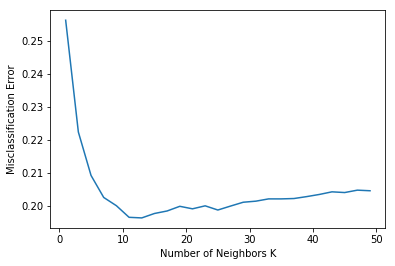

Training accuracy for K = 13 is 80.37


In [21]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
neighbors = list(range(1,50,2))
# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
print ("Training accuracy for K =",optimal_k,'is',round(max(cv_scores)*100,2) )

In [22]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
start_time = time.time()
knn.fit( xtrain, Ytrain)
traingTime=time.time() - start_time
# model = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree').fit(X_train, Y_train)

In [23]:
pred=knn.predict(xtest)

In [24]:
acc_BoW=accuracy_score(Ytest,pred,normalize=True)

In [25]:
print('Test accuracy',round(acc_BoW*100,2),' for k=',optimal_k,'Average time taken training in (seconds)' 
      ,round(traingTime,2))

Test accuracy 78.7  for k= 13 Average time taken training in (seconds) 0.0


# TF-IDF

In [26]:
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()
Xtrain_tf_idf = tf_idf_vect.fit_transform(X_train.values)
Xtest_tf_idf = tf_idf_vect.transform(X_test.values)

In [27]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(Xtrain_tf_idf, Ytrain)
model = SelectFromModel(lsvc, prefit=True)
xtrain_tf = model.transform(Xtrain_tf_idf)
xtest_tf = model.transform(Xtest_tf_idf)

In [28]:
cv_scores_1 = []
timelist_1=[] 


for k in range(1,50,2):
    start_time = time.time()
    knn_1 = KNeighborsClassifier(n_neighbors=k)
    
    scores = cross_val_score(knn_1, xtrain_tf, Ytrain, cv=10, scoring='accuracy')
    t=time.time() - start_time
    print("Neighbour k = ",k,"; time taken",int(time.time() - start_time),'seconds;','Accuracy =',round(scores.mean()*100,2))
    t=time.time() - start_time
    timelist_1.append(t)
    
    cv_scores_1.append(scores.mean())

Neighbour k =  1 ; time taken 12 seconds; Accuracy = 75.35
Neighbour k =  3 ; time taken 13 seconds; Accuracy = 77.93
Neighbour k =  5 ; time taken 17 seconds; Accuracy = 79.1
Neighbour k =  7 ; time taken 17 seconds; Accuracy = 79.65
Neighbour k =  9 ; time taken 17 seconds; Accuracy = 79.96
Neighbour k =  11 ; time taken 17 seconds; Accuracy = 79.92
Neighbour k =  13 ; time taken 17 seconds; Accuracy = 79.99
Neighbour k =  15 ; time taken 17 seconds; Accuracy = 80.42
Neighbour k =  17 ; time taken 18 seconds; Accuracy = 80.46
Neighbour k =  19 ; time taken 17 seconds; Accuracy = 80.59
Neighbour k =  21 ; time taken 17 seconds; Accuracy = 80.87
Neighbour k =  23 ; time taken 17 seconds; Accuracy = 80.87
Neighbour k =  25 ; time taken 17 seconds; Accuracy = 80.6
Neighbour k =  27 ; time taken 17 seconds; Accuracy = 80.72
Neighbour k =  29 ; time taken 17 seconds; Accuracy = 80.94
Neighbour k =  31 ; time taken 17 seconds; Accuracy = 80.79
Neighbour k =  33 ; time taken 17 seconds; Accu

The optimal number of neighbors is 29


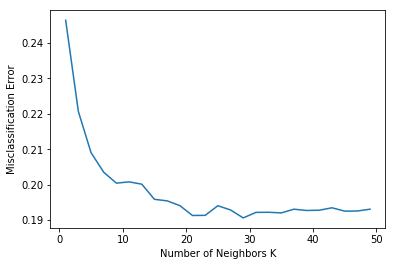

Training accuracy for K = 29 is 80.94


In [29]:
#  changing to misclassification error
MSE_1 = [1 - x for x in cv_scores_1]
neighbors_1 = list(range(1,50,2))
# determining best k
optimal_k_1 = neighbors[MSE_1.index(min(MSE_1))]
print ("The optimal number of neighbors is %d" % optimal_k_1)

# plot misclassification error vs k
plt.plot(neighbors_1, MSE_1)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
print ("Training accuracy for K =",optimal_k_1,'is',round(max(cv_scores_1)*100,2) )

In [30]:
knn_1 = KNeighborsClassifier(n_neighbors=optimal_k_1)
start_time = time.time()
knn_1.fit( xtrain_tf, Ytrain)
traingTime=time.time() - start_time
# model = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree').fit(X_train, Y_train)

In [31]:
predic=knn_1.predict(xtest_tf)

In [32]:
acc_TF=accuracy_score(Ytest,predic,normalize=True)

In [33]:
print('Test accuracy',round(acc_TF*100,2),' for k=',optimal_k_1)

Test accuracy 79.61  for k= 29


# Avg. W2V

In [34]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [35]:
def list_of_sent(df):
    i=0
    list_sent=[]
    for sent in df.values:
        filtered_sentence=[]
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):    
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue 
        
        list_sent.append(filtered_sentence)
    
    return list_sent

In [36]:
W2VTraining_list = list_of_sent(X_train)
W2VTest_list = list_of_sent(X_test)
# W2VTraining_list
list_all_words = list_of_sent(X['WoutStopWords'])

In [37]:
w2v_model = Word2Vec(list_all_words,min_count=5,size=50, workers=4)
words = list(w2v_model.wv.vocab)
print(len(words))

8505


In [38]:
Traing_vectors = []# the avg-w2v for each sentence/review is stored in this list
for sent in W2VTraining_list: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    Traing_vectors.append(sent_vec)
    

In [39]:
cv_scores_2 = []
timelist_2=[] 


for k in range(1,50,2):
    start_time = time.time()
    knn_2 = KNeighborsClassifier(n_neighbors=k)
    
    scores = cross_val_score(knn_2, Traing_vectors, Ytrain, cv=10, scoring='accuracy')
    t=time.time() - start_time
    print("Neighbour k = ",k,"; time taken",int(time.time() - start_time),'seconds;','Accuracy =',round(scores.mean()*100,2))
    t=time.time() - start_time
    timelist_2.append(t)
    
    cv_scores_2.append(scores.mean())

Neighbour k =  1 ; time taken 72 seconds; Accuracy = 75.85
Neighbour k =  3 ; time taken 77 seconds; Accuracy = 79.13
Neighbour k =  5 ; time taken 78 seconds; Accuracy = 80.46
Neighbour k =  7 ; time taken 80 seconds; Accuracy = 81.04
Neighbour k =  9 ; time taken 81 seconds; Accuracy = 81.4
Neighbour k =  11 ; time taken 81 seconds; Accuracy = 81.81
Neighbour k =  13 ; time taken 83 seconds; Accuracy = 81.89
Neighbour k =  15 ; time taken 82 seconds; Accuracy = 81.99
Neighbour k =  17 ; time taken 83 seconds; Accuracy = 82.07
Neighbour k =  19 ; time taken 87 seconds; Accuracy = 82.06
Neighbour k =  21 ; time taken 83 seconds; Accuracy = 82.11
Neighbour k =  23 ; time taken 83 seconds; Accuracy = 82.14
Neighbour k =  25 ; time taken 84 seconds; Accuracy = 82.03
Neighbour k =  27 ; time taken 84 seconds; Accuracy = 82.01
Neighbour k =  29 ; time taken 84 seconds; Accuracy = 82.05
Neighbour k =  31 ; time taken 85 seconds; Accuracy = 81.95
Neighbour k =  33 ; time taken 84 seconds; Acc

The optimal number of neighbors is 23


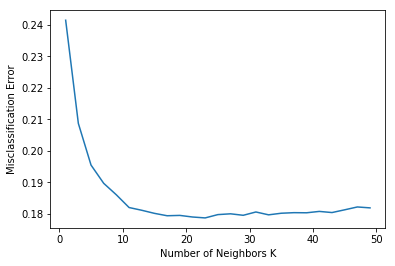

Training accuracy for K = 23 is 82.14


In [40]:
MSE_2 = [1 - x for x in cv_scores_2]
neighbors_2 = list(range(1,50,2))
# determining best k
optimal_k_2 = neighbors[MSE_2.index(min(MSE_2))]
print ("The optimal number of neighbors is %d" % optimal_k_2)

# plot misclassification error vs k
plt.plot(neighbors_2, MSE_2)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
print ("Training accuracy for K =",optimal_k_2,'is',round(max(cv_scores_2)*100,2) )

In [41]:
Test_vectors = []# the avg-w2v for each sentence/review is stored in this list
for sent in W2VTest_list: # for each review/sentence
    i=0
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =1 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
#     i+=1
    sent_vec /= cnt_words
    
#     print(i,'\t',cnt_words)
    Test_vectors.append(sent_vec)
    

In [42]:
knn_2 = KNeighborsClassifier(n_neighbors=optimal_k_2)
start_time = time.time()
knn_2.fit(Traing_vectors, Ytrain)
traingTime=time.time() - start_time

In [43]:
pred_avgw2v=knn_2.predict(Test_vectors)

In [44]:
acc_avgw2v=accuracy_score(Ytest,pred_avgw2v,normalize=True)

In [45]:
print('Test accuracy',round(acc_avgw2v*100,2),' for k=',optimal_k_2)

Test accuracy 80.52  for k= 23


# TFIDF-W2V

In [46]:
tfidf_feat = tf_idf_vect.get_feature_names() 
# tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in W2VTraining_list: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
#             print(vec)
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = Xtrain_tf_idf[row, tfidf_feat.index(word)]
#             print(tfidf)
            sent_vec += (vec * tfidf)
#             print(sent_vec)
        
            weight_sum += tfidf
#             print(weight_sum)
        except:
            pass
    sent_vec /= weight_sum
#     print(sent_vec)
    tfidf_train_vectors.append(sent_vec)
    row += 1
    

In [47]:
cv_scores_3 = []
timelist_3=[] 


for k in range(1,50,2):
    start_time = time.time()
    knn_3 = KNeighborsClassifier(n_neighbors=k)
    
    scores = cross_val_score(knn_3, tfidf_train_vectors, Ytrain, cv=10, scoring='accuracy')
    t=time.time() - start_time
    print("Neighbour k = ",k,"; time taken",int(time.time() - start_time),'seconds;','Accuracy =',round(scores.mean()*100,2))
    t=time.time() - start_time
    timelist_3.append(t)
    
    cv_scores_3.append(scores.mean())
    

Neighbour k =  1 ; time taken 59 seconds; Accuracy = 74.21
Neighbour k =  3 ; time taken 64 seconds; Accuracy = 77.66
Neighbour k =  5 ; time taken 67 seconds; Accuracy = 79.07
Neighbour k =  7 ; time taken 68 seconds; Accuracy = 79.99
Neighbour k =  9 ; time taken 69 seconds; Accuracy = 80.36
Neighbour k =  11 ; time taken 70 seconds; Accuracy = 80.5
Neighbour k =  13 ; time taken 71 seconds; Accuracy = 80.77
Neighbour k =  15 ; time taken 71 seconds; Accuracy = 80.69
Neighbour k =  17 ; time taken 72 seconds; Accuracy = 80.73
Neighbour k =  19 ; time taken 73 seconds; Accuracy = 80.82
Neighbour k =  21 ; time taken 73 seconds; Accuracy = 80.78
Neighbour k =  23 ; time taken 73 seconds; Accuracy = 80.75
Neighbour k =  25 ; time taken 74 seconds; Accuracy = 80.73
Neighbour k =  27 ; time taken 74 seconds; Accuracy = 80.72
Neighbour k =  29 ; time taken 75 seconds; Accuracy = 80.76
Neighbour k =  31 ; time taken 75 seconds; Accuracy = 80.78
Neighbour k =  33 ; time taken 75 seconds; Acc

The optimal number of neighbors is 43


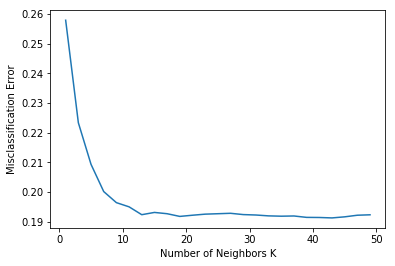

Training accuracy for K = 43 is 80.87


In [48]:
MSE_3 = [1 - x for x in cv_scores_3]
neighbors_3 = list(range(1,50,2))
# determining best k
optimal_k_3 = neighbors[MSE_3.index(min(MSE_3))]
print ("The optimal number of neighbors is %d" % optimal_k_3)

# plot misclassification error vs k
plt.plot(neighbors_3, MSE_3)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()
print ("Training accuracy for K =",optimal_k_3,'is',round(max(cv_scores_3)*100,2) )

In [49]:
tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in W2VTest_list: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =1; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
#             print(vec)
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = Xtest_tf_idf[row, tfidf_feat.index(word)]
#             print(tfidf)
            sent_vec += (vec * tfidf)
#             print(sent_vec)
        
            weight_sum += tfidf
#             print(weight_sum)
        except:
            pass
    sent_vec /= weight_sum
#     print(sent_vec)
    tfidf_test_vectors.append(sent_vec)
    row += 1
    

In [50]:
knn_3 = KNeighborsClassifier(n_neighbors=optimal_k_3)
start_time = time.time()
knn_3.fit(tfidf_train_vectors, Ytrain)
traingTime=time.time() - start_time

In [51]:
pred_tfidw2v=knn_3.predict(tfidf_test_vectors)

In [52]:
acc_tfidw2v=accuracy_score(Ytest,pred_tfidw2v,normalize=True)

In [53]:
print('Test accuracy',round(acc_tfidw2v*100,2),' for k=',optimal_k_3)

Test accuracy 78.67  for k= 43


# __*RESULTS*__

In [54]:
print("Vectroziation method \t optimal K \t Training Accuracy \t Test Accuracy")
print("-------------------- \t ----------\t ----------------- \t -------------")
print(" Bag of Words \t\t  ",optimal_k,'\t\t\t',round(max(cv_scores)*100,2),'\t\t  ',round((acc_BoW)*100,2))
print(" TFID         \t\t  ",optimal_k_1,'\t\t\t',round(max(cv_scores_1)*100,2),'\t\t  ',round((acc_TF)*100,2))
print(" TFID W2V     \t\t  ",optimal_k_2,'\t\t\t',round(max(cv_scores_2)*100,2),'\t\t  ',round((acc_avgw2v)*100,2))
print(" Avg W2V      \t\t  ",optimal_k_3,'\t\t\t',round(max(cv_scores_3)*100,2),'\t\t  ',round((acc_tfidw2v)*100,2))


Vectroziation method 	 optimal K 	 Training Accuracy 	 Test Accuracy
-------------------- 	 ----------	 ----------------- 	 -------------
 Bag of Words 		   13 			 80.37 		   78.7
 TFID         		   29 			 80.94 		   79.61
 TFID W2V     		   23 			 82.14 		   80.52
 Avg W2V      		   43 			 80.87 		   78.67
